In [1]:
import os
import sys
import json
import torch
import numpy as np

import scipy.io
import matplotlib
from scipy import ndimage
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':10,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM
import PIL
from torch.utils import data
from torch.utils.data import DataLoader

Global seed set to 42


In [2]:
def calc_pc_uniform_circle(npt=10001):
    theta = np.linspace(0,2*np.pi,npt,endpoint=False)
    radius = 0.25
    x = radius*np.cos(theta)
    y = radius*np.sin(theta)
    pc = np.hstack((x[:,np.newaxis],y[:,np.newaxis]))
    normals = pc/radius

    # shift the point cloud to centre of the domain
    pc = pc + 0.5

    # pt_cloud = []
    # for _ in range(1000):
    #     vec = np.random.randn(2)
    #     vec /= 4*np.linalg.norm(vec)
    #     pt_cloud.append(vec)
    # pt_cloud = np.array(pt_cloud)
    # self.normals = pt_cloud*4.0
    # self.pc = pt_cloud + 0.5
    return pc, normals

In [3]:
def im_io(filepath):
    image = io.imread(filepath).astype(bool).astype(float)
    

    return im2pc(image)

def im2pc(image, nx, ny):
    pc = []
    normals = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] == 1.0:
                boundary = 0
                if i < image.shape[0] - 1:
                    if image[i+1,j] == 0:
                        boundary = 1
                if j < image.shape[1] - 1:
                    if image[i,j+1] == 0:
                        boundary = 1
                if i > 0:
                    if image[i-1,j] == 0:
                        boundary = 1
                if j > 0:
                    if image[i,j-1] == 0:
                        boundary = 1
                if i < image.shape[0] - 1  and j < image.shape[1] - 1:
                    if image[i+1,j+1] == 0:
                        boundary = 1
                if i < image.shape[0] - 1  and j > 0:
                    if image[i+1,j-1] == 0:
                        boundary = 1
                if i > 0 and j < image.shape[1] - 1:
                    if image[i-1,j+1] == 0:
                        boundary = 1
                if i > 0 and j > 0:
                    if image[i-1,j-1] == 0:
                        boundary = 1
                if boundary == 1:
                    pc.append([i+0.5,j+0.5])
                    normals.append([nx[i,j]/(nx[i,j]**2 + ny[i,j]**2), ny[i,j]/(nx[i,j]**2 + ny[i,j]**2)])
    return np.array(pc), np.array(normals)

In [4]:
def plot_contours(self, u):
        fig, axs = plt.subplots(1, 3, figsize=(3.5*3,2.4),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        # error
        err = u - self.dataset.u_exact
        err = np.where(self.dataset.condition_arr, np.zeros_like(err), err)
        h = 1./self.domain_size
        errl2 = np.linalg.norm(err, 'fro')/self.domain_size
        errinf = np.max(err)
        im0 = axs[0].imshow(u,cmap='jet')
        fig.colorbar(im0, ax=axs[0])
        im1 = axs[1].imshow(self.dataset.u_exact,cmap='jet')
        fig.colorbar(im1, ax=axs[1])  
        im = axs[2].imshow(err,cmap='jet')
        fig.colorbar(im, ax=axs[2])  
#         im0 = axs[0].contourf(self.dataset.x, self.dataset.y, u,cmap='jet')
#         fig.colorbar(im0, ax=axs[0])
#         im1 = axs[1].contourf(self.dataset.x, self.dataset.y, self.dataset.u_exact,cmap='jet')
#         fig.colorbar(im1, ax=axs[1])  
#         im = axs[2].contourf(self.dataset.x, self.dataset.y, err,cmap='jet')
#         fig.colorbar(im, ax=axs[2])  
#         plt.suptitle("h = {:4f}, el2 = {:6f}, el_inf = {:5f}".format(h, errl2, errinf))
        print("h = {:4f}, el2 = {:6f}, el_inf = {:5f}".format(h, errl2, errinf))
#         plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
#         self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
#         plt.close('all')

In [5]:
class PCVox(data.Dataset):
    'PyTorch dataset for PCVox'
    def __init__(self, domain_size=128, **kwargs):
        """
        Initialization
        """
#         file, ext = os.path.splitext(filename)
#         if ext in ['.png', '.jpg', '.bmp', '.tiff']:
#             img = PIL.Image.open(filename).convert('L')
#             # img = PIL.Image.open(filename).convert('L').resize((700, 300))
#             img = (np.asarray(img)>0).astype('float')
#         else:
#             raise ValueError('invalid extension; extension not supported')

#         # Define kernel for x differences
#         kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
#         # Define kernel for y differences
#         ky = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]])
#         # Perform x convolution
#         nx = ndimage.convolve(img,kx)
#         # Perform y convolution
#         ny = ndimage.convolve(img,ky)
#         nx = np.divide(nx,(nx**2 + ny**2), out=np.zeros_like(nx), where=((nx**2 + ny**2)!=0))
#         ny = np.divide(ny,(nx**2 + ny**2), out=np.zeros_like(ny), where=((nx**2 + ny**2)!=0))
        
        x = np.linspace(0, 1, domain_size)
        y = np.linspace(0, 1, domain_size)

        xx , yy = np.meshgrid(x, y)
        self.x = xx
        self.y = yy
        
        rdisk = 0.25
        self.condition_arr = ((xx-0.5)**2+(yy-0.5)**2) > rdisk**2
        
        self.u_exact = (rdisk**2-((xx-0.5)**2+(yy-0.5)**2))/4.
        self.u_exact = np.where(self.condition_arr, np.zeros_like(xx), self.u_exact)
        # bc1 for outer boundary
        self.bc1 = np.zeros_like(xx)
        self.bc1 = np.where(self.condition_arr, 1., self.bc1)
        
        self.forcing = np.ones_like(xx)
#         self.forcing = np.where(condition_arr, 0., self.forcing)

        # bc1 will be source, sdf will be set to 0.5 at these locations
#         self.pc, self.normals = im2pc(img,nx,ny)
#         self.pc = self.pc/(img.shape[0])
        npt_circle = kwargs.get('npt_circle', 10001)
        self.pc, self.normals = calc_pc_uniform_circle(npt_circle)
        
        self.domain = np.ones((domain_size,domain_size))
        self.domain_size = domain_size
        self.n_samples = 100

    def __len__(self):
        'Denotes the total number of samples'
        return self.n_samples

    def __getitem__(self, index):
        'Generates one sample of data'
        inputs = np.array([self.pc, self.normals]) # 2, Npoint, 2
        #forcing = np.ones_like(self.domain)
        forcing = self.forcing
        return torch.FloatTensor(inputs), torch.FloatTensor(forcing).unsqueeze(0)

In [6]:
class Poisson(DiffNet2DFEM):
    """docstring for Poisson"""
    def __init__(self, network, dataset, **kwargs):
        super(Poisson, self).__init__(network, **kwargs)
        self.dataset = dataset

    def loss(self, u, inputs_tensor, forcing_tensor):

        f = forcing_tensor # renaming variable
        
        # extract diffusivity and boundary conditions here
        pc = inputs_tensor[:,0:1,:,:]
        normals = inputs_tensor[:,1:2,:,:]
        bc1 = torch.FloatTensor(self.dataset.bc1).unsqueeze(0).unsqueeze(0).type_as(u)
        
#         u = torch.where(bc1>0.5,torch.zeros_like(u),u)
        
#         if self.current_epoch == 3:
#             plt.imshow(u.squeeze().detach().cpu().numpy())
#             plt.colorbar()
#             plt.show()
#             return
        
        # init bin widths
        hx = self.h
        hy = self.h

        # apply boundary conditions
        nidx = (pc[:,:,:,0]/self.hx).type(torch.LongTensor).to(pc.device)
        nidy = (pc[:,:,:,1]/self.hy).type(torch.LongTensor).to(pc.device)

        u_pts_grid =  torch.stack([
                torch.stack([
                    torch.stack([u[b,0,nidx[b,0,:],nidy[b,0,:]] for b in range(u.size(0))]),
                    torch.stack([u[b,0,nidx[b,0,:]+1,nidy[b,0,:]] for b in range(u.size(0))])]),
                torch.stack([
                    torch.stack([u[b,0,nidx[b,0,:],nidy[b,0,:]+1] for b in range(u.size(0))]),
                    torch.stack([u[b,0,nidx[b,0,:]+1,nidy[b,0,:]+1] for b in range(u.size(0))])])
                ]).unsqueeze(2)

        x_pts = pc[:,:,:,0] - nidx.type_as(pc)*self.hx 
        y_pts = pc[:,:,:,1] - nidy.type_as(pc)*self.hy

        xi_pts = (x_pts*2)/self.hx - 1
        eta_pts = (y_pts*2)/self.hy - 1

        # print(xi_pts, eta_pts)

        N_values_pts = self.bf_1d_th(xi_pts).unsqueeze(0)*self.bf_1d_th(eta_pts).unsqueeze(1)
        dN_x_values_pts = self.bf_1d_der_th(xi_pts).unsqueeze(0)*self.bf_1d_th(eta_pts).unsqueeze(1)
        dN_y_values_pts = self.bf_1d_th(xi_pts).unsqueeze(0)*self.bf_1d_der_th(eta_pts).unsqueeze(1)

        u_pts = torch.sum(torch.sum(N_values_pts*u_pts_grid,0),0)
        u_x_pts = torch.sum(torch.sum(dN_x_values_pts*u_pts_grid,0),0)
        u_y_pts = torch.sum(torch.sum(dN_y_values_pts*u_pts_grid,0),0)

        # nu_gp = self.gauss_pt_evaluation(nu)
        f_gp = self.gauss_pt_evaluation(f)
        u_gp = self.gauss_pt_evaluation(u)
        u_x_gp = self.gauss_pt_evaluation_der_x(u)
        u_y_gp = self.gauss_pt_evaluation_der_y(u)

        transformation_jacobian = self.gpw.unsqueeze(-1).unsqueeze(-1).unsqueeze(0).type_as(f)
        res_elmwise = transformation_jacobian * (0.5 * (u_x_gp**2 + u_y_gp**2) - (u_gp * f_gp))
        res_elmwise = torch.sum(res_elmwise, 1)

        loss = torch.mean(res_elmwise) + torch.sum((u_pts-0.0)**2)
        return loss

    def forward(self, batch):
        inputs_tensor, forcing_tensor = batch
        return self.network[0], inputs_tensor, forcing_tensor

    def training_step(self, batch, batch_idx):
        u, inputs_tensor, forcing_tensor = self.forward(batch)
        loss_val = self.loss(u, inputs_tensor, forcing_tensor).mean()
        return {"loss": loss_val}

    def training_step_end(self, training_step_outputs):
        loss = training_step_outputs["loss"]
        self.log('PDE_loss', loss.item())
        self.log('loss', loss.item())
        return training_step_outputs

    def configure_optimizers(self):
        lr = self.learning_rate
        opts = [torch.optim.LBFGS(self.network, lr=1.0, max_iter=5)]
        # opts = [torch.optim.Adam(self.network, lr=lr)]
        return opts, []

    def on_epoch_end(self):
        self.network.eval()
        inputs, forcing = self.dataset[0]
        u = self.do_query(inputs, forcing)
        self.plot_contours(u.squeeze().detach().cpu())

    def do_query(self, inputs, forcing):
        u, inputs_tensor, forcing_tensor = self.forward((inputs.unsqueeze(0).type_as(next(self.network.parameters())), forcing.unsqueeze(0).type_as(next(self.network.parameters()))))

        f = forcing_tensor # renaming variable
        
        # extract diffusivity and boundary conditions here
        # nu = inputs_tensor[:,0:1,:,:]
        # bc1 = inputs_tensor[:,1:2,:,:]
        # bc2 = inputs_tensor[:,2:3,:,:]

        # apply boundary conditions
        # u = torch.where(bc1>0.5,1.0+u*0.0,u)
        # u = torch.where(bc2>0.5,u*0.0,u)

        # nu = nu.squeeze().detach().cpu()
        # u = u.squeeze().detach().cpu()
        bc1 = torch.FloatTensor(self.dataset.bc1).unsqueeze(0).unsqueeze(0).type_as(u)
        u = torch.where(bc1>0.5,torch.zeros_like(u),u)

        return u

    def plot_contours(self, u):
        fig, axs = plt.subplots(1, 3, figsize=(2*3,1.2),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        # error
        err = u - self.dataset.u_exact
        err = np.where(self.dataset.condition_arr, np.zeros_like(err), err)
        h = 1./self.domain_size
        errl2 = np.linalg.norm(err, 'fro')/self.domain_size
        errinf = np.max(err)
        im0 = axs[0].imshow(u,cmap='jet')
        fig.colorbar(im0, ax=axs[0])
        im1 = axs[1].imshow(self.dataset.u_exact,cmap='jet')
        fig.colorbar(im1, ax=axs[1])  
        im = axs[2].imshow(err,cmap='jet')
        fig.colorbar(im, ax=axs[2])  
        plt.suptitle("h = {:4f}, el2 = {:6f}, el_inf = {:5f}".format(h, errl2, errinf))
        plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
        self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
        plt.close('all')

In [7]:
def run_and_calc_err(domain_size, npt_circle):
    dataset = PCVox(domain_size=domain_size, npt_circle=npt_circle)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

    u_tensor = np.ones((1,1,domain_size,domain_size))
    network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
    basecase = Poisson(network, dataset, batch_size=1, domain_size=domain_size)

    # ------------------------
    # 1 INIT TRAINER
    # ------------------------
    logger = pl.loggers.TensorBoardLogger('.', name="pc_poisson_disk")
    csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

    early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
        min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
    checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
        dirpath=logger.log_dir, filename='{epoch}-{step}',
        mode='min', save_last=True)

    # trainer = Trainer(gpus=[0],callbacks=[early_stopping],
    #     checkpoint_callback=checkpoint, logger=[logger,csv_logger],
    #     max_epochs=5, deterministic=True, profiler='simple')
    trainer = pl.Trainer(accelerator='gpu',devices=1,
                         callbacks=[checkpoint],
                         logger=[logger,csv_logger], 
                         max_epochs=5,
                         fast_dev_run=False
                         )
    # ------------------------
    # 4 Training
    # ------------------------

    trainer.fit(basecase, dataloader)

    # ------------------------
    # 5 SAVE NETWORK
    # ------------------------
    torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))
    
    # Query
    basecase.dataset[0]
    inputs, forcing = basecase.dataset[0]
    u = basecase.do_query(inputs, forcing)
    u = u.squeeze().detach().numpy()

    # plot
    plot_contours(basecase, u)
    
    # error
    err = u - dataset.u_exact
    err = np.where(dataset.condition_arr, np.zeros_like(err), err)
    h = 1./domain_size
    errl2 = np.linalg.norm(err, 'fro')/domain_size
    errinf = np.max(err)
    print(errl2, errinf)
    return errl2

In [8]:
npt_circle = 5001

narr = np.array([32,64,128,256])
harr = 1./(narr-1)
earr = np.zeros(narr.shape)

/work/mech-ai/bkhara/python_virtual_envs/lightning/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /work/mech-ai/bkhara/python_virtual_envs/lightning/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/work/mech-ai/bkhara/python_virtual_envs/lightning/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /work/mech-ai/bkhara/python_virtual_envs/lightning/ ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES

Epoch 1:   0%|                                                       | 0/100 [00:00<?, ?it/s, v_num=5]

/work/mech-ai/bkhara/python_virtual_envs/lightning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='loss')` could not find the monitored key in the returned metrics: ['epoch', 'step']. HINT: Did you call `log('loss', value)` in the `LightningModule`?
  warning_cache.warn(m)


Epoch 4: 100%|█████████████████████████████████████████████| 100/100 [00:02<00:00, 48.03it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█████████████████████████████████████████████| 100/100 [00:02<00:00, 47.17it/s, v_num=5]
h = 0.031250, el2 = 0.001279, el_inf = 0.000000
0.0012794018055663817 0.0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | network      | ParameterList | 4.1 K 
1 | N_gp         | ParameterList | 16    
2 | dN_x_gp      | ParameterList | 16    
3 | dN_y_gp      | ParameterList | 16    
4 | d2N_x_gp     | ParameterList | 16    
5 | d2N_y_gp     | ParameterList | 16    
6 | d2N_xy_gp    | ParameterList | 16    
7 | N_gp_surf    | ParameterList | 4     
8 | dN_x_gp_surf | ParameterList | 4     
9 | dN_y_gp_surf | ParameterList | 4     
-----------------------------------------------
4.1 K     Trainable params
108       Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)
/work/mech-ai/bkhara/python_virtual_envs/lightning/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:1

Epoch 4: 100%|█████████████████████████████████████████████| 100/100 [00:02<00:00, 47.57it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█████████████████████████████████████████████| 100/100 [00:02<00:00, 46.52it/s, v_num=6]
h = 0.015625, el2 = 0.000518, el_inf = 0.000000
0.0005184026583110497 0.0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | network      | ParameterList | 16.4 K
1 | N_gp         | ParameterList | 16    
2 | dN_x_gp      | ParameterList | 16    
3 | dN_y_gp      | ParameterList | 16    
4 | d2N_x_gp     | ParameterList | 16    
5 | d2N_y_gp     | ParameterList | 16    
6 | d2N_xy_gp    | ParameterList | 16    
7 | N_gp_surf    | ParameterList | 4     
8 | dN_x_gp_surf | ParameterList | 4     
9 | dN_y_gp_surf | ParameterList | 4     
-----------------------------------------------
16.4 K    Trainable params
108       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
/work/mech-ai/bkhara/python_virtual_envs/lightning/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:1

Epoch 4: 100%|█████████████████████████████████████████████| 100/100 [00:02<00:00, 47.15it/s, v_num=7]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█████████████████████████████████████████████| 100/100 [00:02<00:00, 45.28it/s, v_num=7]
h = 0.007812, el2 = 0.000165, el_inf = 0.000112
0.0001645374642882379 0.00011153767707236181


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | network      | ParameterList | 65.5 K
1 | N_gp         | ParameterList | 16    
2 | dN_x_gp      | ParameterList | 16    
3 | dN_y_gp      | ParameterList | 16    
4 | d2N_x_gp     | ParameterList | 16    
5 | d2N_y_gp     | ParameterList | 16    
6 | d2N_xy_gp    | ParameterList | 16    
7 | N_gp_surf    | ParameterList | 4     
8 | dN_x_gp_surf | ParameterList | 4     
9 | dN_y_gp_surf | ParameterList | 4     
-----------------------------------------------
65.5 K    Trainable params
108       Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)
/work/mech-ai/bkhara/python_virtual_envs/lightning/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:1

Epoch 4: 100%|█████████████████████████████████████████████| 100/100 [00:01<00:00, 56.25it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█████████████████████████████████████████████| 100/100 [00:02<00:00, 49.28it/s, v_num=8]
h = 0.003906, el2 = 0.000011, el_inf = 0.000302
1.1325562740193192e-05 0.0003020792086589029


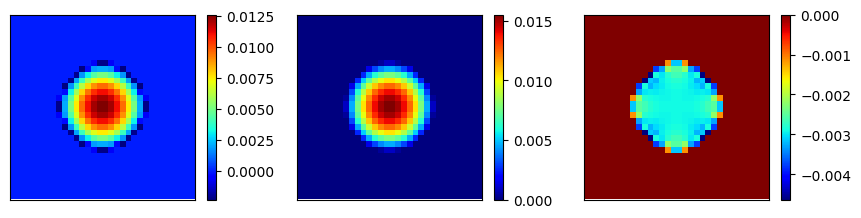

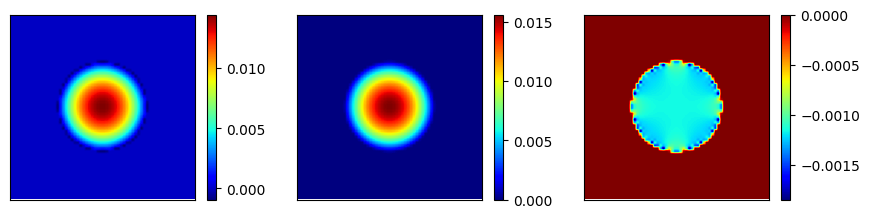

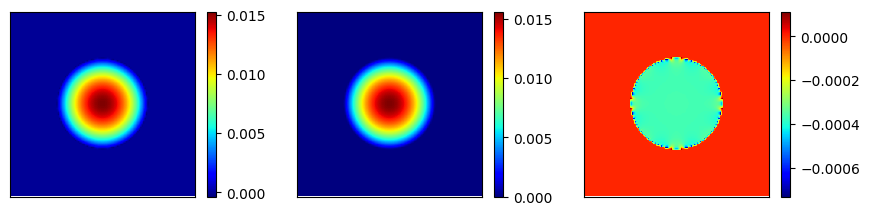

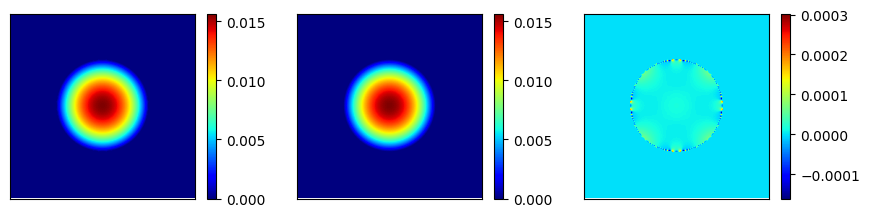

In [9]:
for j in range(narr.shape[0]):
    earr[j] = run_and_calc_err(narr[j], npt_circle)

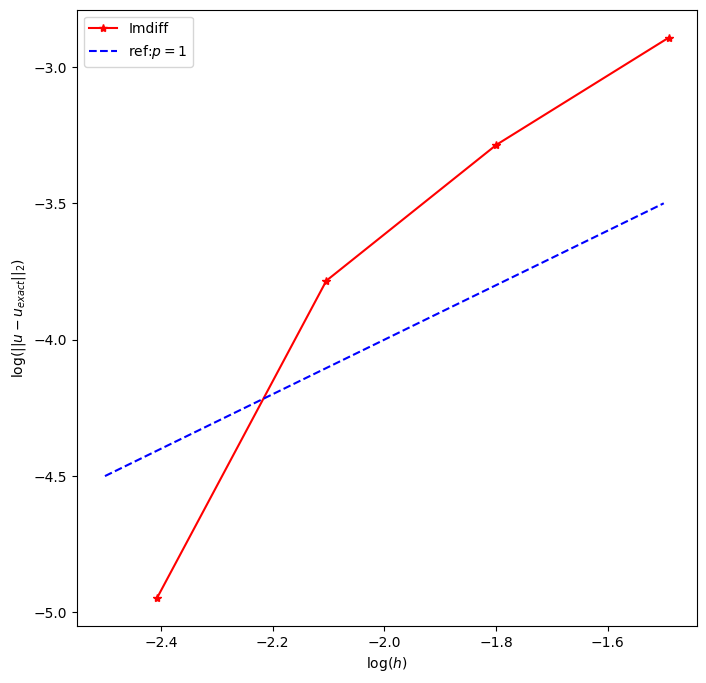

In [10]:
t = np.linspace(-2.5,-1.5,50)
ref1 = 1*t-2
ref2 = 2*t-1
plt.figure(figsize=(8,8))
plt.plot(np.log10(harr[0:4]), np.log10(earr[0:4]),'r*-', label='Imdiff')
plt.plot(t,ref1,'b--', label=r'ref:$p=1$')
# plt.plot(t,ref2,'k--', label=r'ref:$p=2$')
plt.xlabel("log($h$)")
plt.ylabel(r"$\log(||u-u_{exact}||_2)$")
plt.legend()